In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

import scipy.io
from sklearn.feature_selection import mutual_info_regression

from tqdm import tqdm

sns.set_style("white")

plt.rcParams.update({                      
    "font.monospace": [],
    "figure.figsize": (12,8),
    "axes.labelsize": 12,               # LaTeX default is 10pt font.
    "font.size": 11,
    "legend.fontsize": 10,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
    })

C:\Users\ameyv\anaconda3\envs\pinn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size)))
            layers.append(('--activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [11]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)
        
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1, self.h)
        t = torch.arange(0, 1, self.k)

        # exact solution
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
        
        # training data
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
    def loss_func(self):
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        u = self.model(self.X)

        du_dX = torch.autograd.grad(inputs=self.X, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(inputs=self.X, outputs=du_dX, grad_outputs=torch.ones_like(du_dX), retain_graph=True, create_graph=True)[0][:, 0]
#         print(u.shape, du_dt.shape, du_dx.shape, du_dxx.shape)
        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, 0.01 / math.pi * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        for i in range(10000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

# Training

In [12]:
net = Net()
net.train()

100 0.17301258444786072
200 0.09119952470064163
300 0.07790889590978622
400 0.0649837777018547
500 0.042887914925813675
600 0.029112622141838074
700 0.02126925252377987
800 0.017835281789302826
900 0.015036634169518948
1000 0.012645424343645573
1100 0.011011183261871338
1200 0.010772880166769028
1300 0.008989561349153519
1400 0.008583451621234417
1500 0.008279954083263874
1600 0.007191489450633526
1700 0.006570195779204369
1800 0.006579969078302383
1900 0.019326800480484962
2000 0.008974647149443626
2100 0.006805848330259323
2200 0.005384103395044804
2300 0.004932189825922251
2400 0.004741780459880829
2500 0.005134449806064367
2600 0.004270158242434263
2700 0.0040040588937699795
2800 0.004158223979175091
2900 0.005099139641970396
3000 0.004167377948760986
3100 0.003921447321772575
3200 0.0034421386662870646
3300 0.003043197561055422
3400 0.004002354107797146
3500 0.003372454084455967
3600 0.0025893445126712322
3700 0.0026624626480042934
3800 0.0036503784358501434
3900 0.002919097896665

# Evaluation

In [13]:
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

In [14]:
print(x.shape)
print(t.shape)
print(X.shape)
print(X)

torch.Size([200])
torch.Size([100])
torch.Size([20000, 2])
tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0100],
        [-1.0000,  0.0200],
        ...,
        [ 0.9900,  0.9700],
        [ 0.9900,  0.9800],
        [ 0.9900,  0.9900]])


In [15]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

<Axes: >

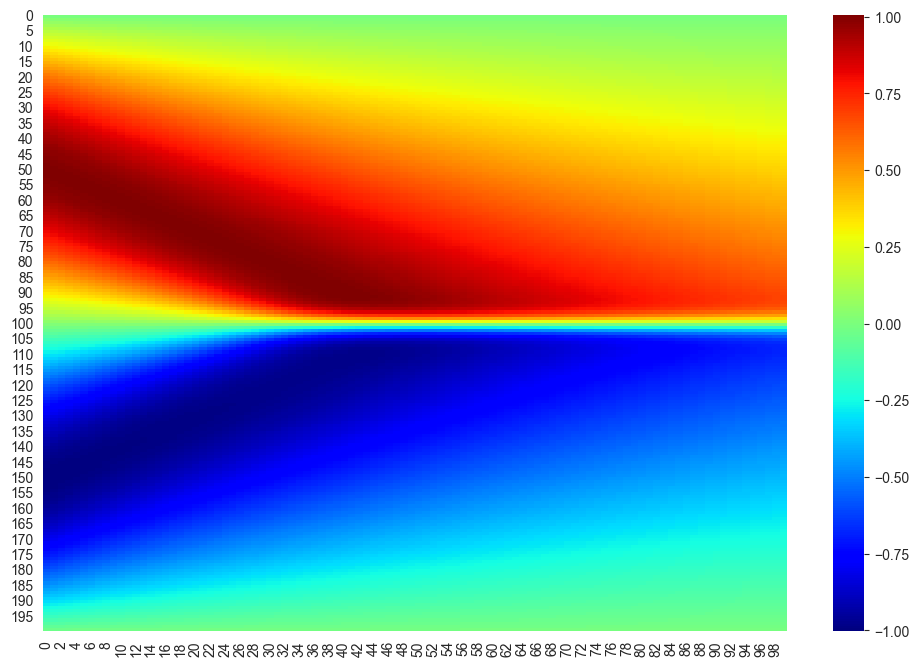

In [16]:
sns.heatmap(y_pred, cmap='jet')

# Save Result

In [17]:
print(y_pred.shape)
print(y_pred)

(200, 100)
[[ 0.002583    0.00219178  0.00187367 ... -0.00143713 -0.00142202
  -0.00140549]
 [ 0.03407986  0.03274913  0.03154582 ...  0.00616057  0.00611643
   0.00607552]
 [ 0.06539874  0.06313746  0.06105666 ...  0.01376766  0.01366439
   0.01356553]
 ...
 [-0.09720136 -0.09436433 -0.0916914  ... -0.02487184 -0.02468674
  -0.02450539]
 [-0.06458938 -0.0627474  -0.0610138  ... -0.01685254 -0.01672755
  -0.0166055 ]
 [-0.03150259 -0.030689   -0.02992652 ... -0.00881366 -0.00874957
  -0.00868706]]


In [18]:
mat = {'v': y_pred}
scipy.io.savemat('burgers_pinn.mat', mat)